In [40]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import warnings; warnings.simplefilter('ignore')
import math
from matplotlib.patches import Circle
import itertools
import numpy.linalg
from IPython.display import clear_output, display
from matplotlib import colors
matplotlib.rc('font',family='Arial')
from matplotlib.lines import Line2D
import os
import math
ppmm = 2.75 
track_directory = "/Users/mrat0010/Documents/GitHub/Polytrack_WIP/data/output/Ratnayake2023_processed_CV4A/filtered"
# track_directory = "/Users/mrat0010/Documents/GitHub/Polytrack_WIP/data/output/Ratnayake2023_processed_CV4A/Polytrack_Raw3"

In [41]:

# Initialize an empty DataFrame
insect_tracks = pd.DataFrame()
# Create the dataframe
track_summary = pd.DataFrame(columns=['insect_num', 'insect_type', 'track_distance', 'flowers_visited'])
insect_info = []


# Walk through all subdirectories in the track_directory
for root, dirs, files in os.walk(track_directory):
    for file in files:
        # Check if the file is a CSV and contains one of the target names
        if file.endswith('.csv') and ('honeybee' in file or 'hoverfly' in file or 'moth' in file or 'wasp' in file):
            # Construct the full filepath
            filepath = os.path.join(root, file)
            # Load the CSV file into a DataFrame
            df = pd.read_csv(filepath)
            

            # Extract the insect name from the filename
            filename = os.path.basename(filepath)
            insect_name = filename.split('_')[6].split('.')[0]
            camera_direction = filename.split('_')[2].split('.')[0]
            insect_number = filename.split('_')[7].split('.')[0]
            insect_info.append((f'{insect_name}_{insect_number}'))

            # Remove blank spaces in the column names
            df.columns = df.columns.str.strip()


            # If camera_direction is "S", y_adj = 1080 - y, else y_adj=y
            if camera_direction == 'N':
                df['y'] = 1080 - df['y']

            # Convert the x and y columns to mm by dividing by the pixels per mm
            df['x'] = df['x'] / ppmm
            df['y'] = df['y'] / ppmm

            # Smooth out the data in x and y columns using a rolling average
            df['x'] = df['x'].rolling(10, min_periods=1).mean()
            df['y'] = df['y'].rolling(10, min_periods=1).mean()

            total_distance = calculate_total_distance(df, 'x', 'y')
            flowers_visited = filter_and_extract_unique_sequences(df, 'flower', 2)

            insect_data = [insect_number, insect_name, total_distance, len(flowers_visited)]
            track_summary.loc[len(track_summary)] = insect_data
            

            # Rename the columns to include the insect number and insect name
            df.columns = [f'{insect_name}_{insect_number}_{col}' for col in df.columns]

            # add the dataframe to the insect_tracks dataframe
            insect_tracks = pd.concat([insect_tracks, df], axis=1)


insect_tracks

,moth_3004000633_nframe,moth_3004000633_x,moth_3004000633_y,moth_3004000633_flower,honeybee_1001000256_nframe,honeybee_1001000256_x,honeybee_1001000256_y,honeybee_1001000256_flower,honeybee_1005000322_nframe,honeybee_1005000322_x,...,honeybee_1011000803_y,honeybee_1011000803_flower,honeybee_1021000755_nframe,honeybee_1021000755_x,honeybee_1021000755_y,honeybee_1021000755_flower,honeybee_1003000632_nframe,honeybee_1003000632_x,honeybee_1003000632_y,honeybee_1003000632_flower
0,11792.0,597.090909,344.363636,NaN,5305.0,387.272727,146.909091,NaN,6061.0,100.000000,...,146.909091,NaN,14263.0,100.0,357.818182,NaN,11775.0,48.363636,339.636364,NaN
1,11793.0,597.090909,344.363636,NaN,5306.0,387.272727,146.909091,NaN,6062.0,99.818182,...,146.909091,NaN,14264.0,100.0,357.818182,NaN,11776.0,48.363636,339.636364,NaN
2,11794.0,597.090909,344.363636,NaN,5307.0,387.272727,146.909091,NaN,6063.0,99.878788,...,146.909091,NaN,14265.0,100.0,357.818182,NaN,11777.0,48.363636,339.636364,NaN
3,11795.0,597.090909,344.363636,NaN,5308.0,387.272727,146.909091,NaN,6064.0,99.909091,...,146.909091,NaN,14266.0,100.0,357.818182,NaN,11778.0,48.363636,339.636364,NaN
4,11796.0,597.090909,344.363636,NaN,5309.0,387.272727,146.909091,NaN,6065.0,99.909091,...,146.909091,NaN,14267.0,100.0,357.818182,NaN,11779.0,48.363636,339.545455,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12670,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
12671,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
12672,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
12673,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [42]:

def calculate_total_distance(df, x_col, y_col):
    """
    Calculate the total distance of the track using x and y coordinates from a pandas DataFrame.
    
    Parameters:
        df (pd.DataFrame): DataFrame containing x and y coordinates.
        x_col (str): The name of the column containing x coordinates.
        y_col (str): The name of the column containing y coordinates.
    
    Returns:
        float: The total distance of the track.
    """
    # Drop rows where either x or y coordinates are None or NaN
    df_clean = df.dropna(subset=[x_col, y_col])
    
    # Calculate the differences between consecutive coordinates
    dx = df_clean[x_col].diff().dropna()
    dy = df_clean[y_col].diff().dropna()
    
    # Calculate the distances between consecutive points
    distances = np.sqrt(dx**2 + dy**2)
    
    # Sum the distances to get the total distance
    total_distance = distances.sum()
    
    return total_distance

# # Example usage
# data = {
#     'x': [0, 1, 2, 3, None, 4],
#     'y': [0, 1, 1, 2, 2, 3]
# }
# df = pd.DataFrame(data)

# total_distance = calculate_total_distance(df, 'x', 'y')
# print(f'Total distance: {total_distance}')


In [43]:
sorted_summary = track_summary.sort_values(by='track_distance', ascending=False)
sorted_summary

,insect_num,insect_type,track_distance,flowers_visited
9,1007000700,honeybee,1840.419920,0
13,1003000632,honeybee,801.793167,0
8,1003000257,honeybee,764.945011,1
11,1011000803,honeybee,403.564557,0
10,1004000257,honeybee,241.572039,0
3,1008000508,honeybee,141.505016,0
4,1010000656,honeybee,121.748200,0
1,1001000256,honeybee,40.716355,0
5,1030000934,honeybee,2.810337,0
6,1020000742,honeybee,1.090909,0


In [44]:


# Filter track_summary for honeybees and calculate total flowers visited
honeybee_flowers_visited = track_summary[track_summary['insect_type'] == 'honeybee']['flowers_visited'].sum()

# Filter track_summary for wasps and calculate total flowers visited
wasp_flowers_visited = track_summary[track_summary['insect_type'] == 'wasp']['flowers_visited'].sum()

# Filter track_summary for hoverflies and calculate total flowers visited
hoverfly_flowers_visited = track_summary[track_summary['insect_type'] == 'hoverfly']['flowers_visited'].sum()

# Filter track_summary for moths and calculate total flowers visited
moth_flowers_visited = track_summary[track_summary['insect_type'] == 'moth']['flowers_visited'].sum()

# Print the results
print("Total flowers visited by honeybees:", honeybee_flowers_visited)
print("Total flowers visited by wasps:", wasp_flowers_visited)
print("Total flowers visited by hoverflies:", hoverfly_flowers_visited)
print("Total flowers visited by moths:", moth_flowers_visited)

Total flowers visited by honeybees: 1
Total flowers visited by wasps: 0
Total flowers visited by hoverflies: 0
Total flowers visited by moths: 0


In [45]:
import math


def filter_and_extract_unique_sequences(df, column_name,min_frames):
    def is_nan(x):
        return math.isnan(x)
    
    # Step 1: Filter out NaN values
    filtered_lst = df[column_name].dropna().tolist()
    
    # Step 2: Extract sequences
    sequences = []
    current_sequence = []
    
    for value in filtered_lst:
        if not current_sequence or value == current_sequence[-1]:
            current_sequence.append(value)
        else:
            if len(current_sequence) >= min_frames:
                sequences.append(current_sequence[0])
            current_sequence = [value]
    
    # Check the last sequence
    if len(current_sequence) >= min_frames:
        sequences.append(current_sequence[0])
    
    # Ensure unique sequences while preserving order
    unique_sequences = []
    for seq in sequences:
        if seq not in unique_sequences:
            unique_sequences.append(seq)
    
    return unique_sequences



Honeybee Tracks: ['honeybee_1001000256', 'honeybee_1005000322', 'honeybee_1008000508', 'honeybee_1010000656', 'honeybee_1030000934', 'honeybee_1020000742', 'honeybee_1024000845', 'honeybee_1003000257', 'honeybee_1007000700', 'honeybee_1004000257', 'honeybee_1011000803', 'honeybee_1021000755', 'honeybee_1003000632']
Hoverfly Tracks: []
Moth Tracks: ['moth_3004000633']
Wasp Tracks: []


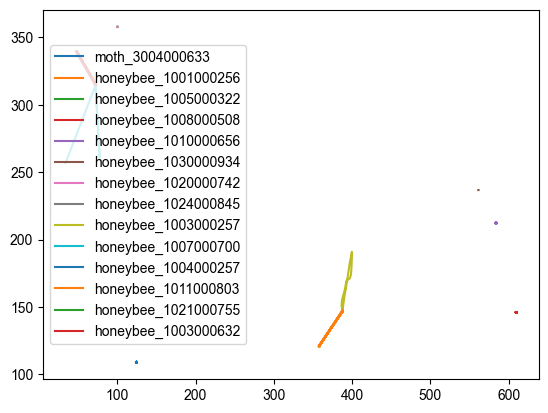

In [46]:
# For all the values in the insect_info list, Plot the x and y values
for insect in insect_info:
    x = insect_tracks[f'{insect}_x']
    y = insect_tracks[f'{insect}_y']
    plt.plot(x, y, label=insect)

plt.legend()

# plt.legend()


def getPlotColor(_insect):
    _insect_type = _insect.split('_')[0]
    # print(_insect_type)
    
    if _insect_type == 'honeybee': _color = '#1f77b4' #blue - honeybee
    elif _insect_type =='hoverfly':_color = '#ff7f0e' #orage - hoverfly
    elif _insect_type == 'moth':_color = '#2ca02c' #green - moth
    elif _insect_type == 'wasp':_color = '#d62728' # red- wasp
    else: _color = '#7f7f7f'
    
    return _color

honeybee_tracks = []
hoverfly_tracks = []
moth_tracks = []
wasp_tracks = []


for insect in insect_info:
    insect_type = insect.split('_')[0]
    if insect_type == 'honeybee':
        honeybee_tracks.append(insect)
    elif insect_type == 'hoverfly':
        hoverfly_tracks.append(insect)
    elif insect_type == 'moth':
        moth_tracks.append(insect)
    elif insect_type == 'wasp':
        wasp_tracks.append(insect)

print("Honeybee Tracks:", honeybee_tracks)
print("Hoverfly Tracks:", hoverfly_tracks)
print("Moth Tracks:", moth_tracks)
print("Wasp Tracks:", wasp_tracks)



In [47]:
# Browse through all subdirectories in the track_directory and add csv files containing names flower_positions to a dataframe called flower_positions
position_number_list = []

flower_positions = pd.DataFrame()
for root, dirs, files in os.walk(track_directory):
    for file in files:
        if file.endswith('.csv') and 'flower_positions' in file:
            filepath = os.path.join(root, file)
            filename = os.path.basename(filepath)
            position_number = filename.split('_')[5].split('.')[0]
            position_number_list.append(position_number)

            camera_direction = filename.split('_')[2].split('.')[0]

            df = pd.read_csv(filepath)
            
            # Remove blank spaces in the column names
            df.columns = df.columns.str.strip()

            if camera_direction == 'N':
                df['cy'] = 1080 - df['cy']

            df['cx'] = df['cx'] / ppmm
            df['cy'] = df['cy'] / ppmm
            df['radius'] = df['radius'] / ppmm

            # Rename the columns to include the position number
            df.columns = [f'{position_number}_{col}' for col in df.columns]

            flower_positions = pd.concat([flower_positions, df], axis=1)


flower_positions

""


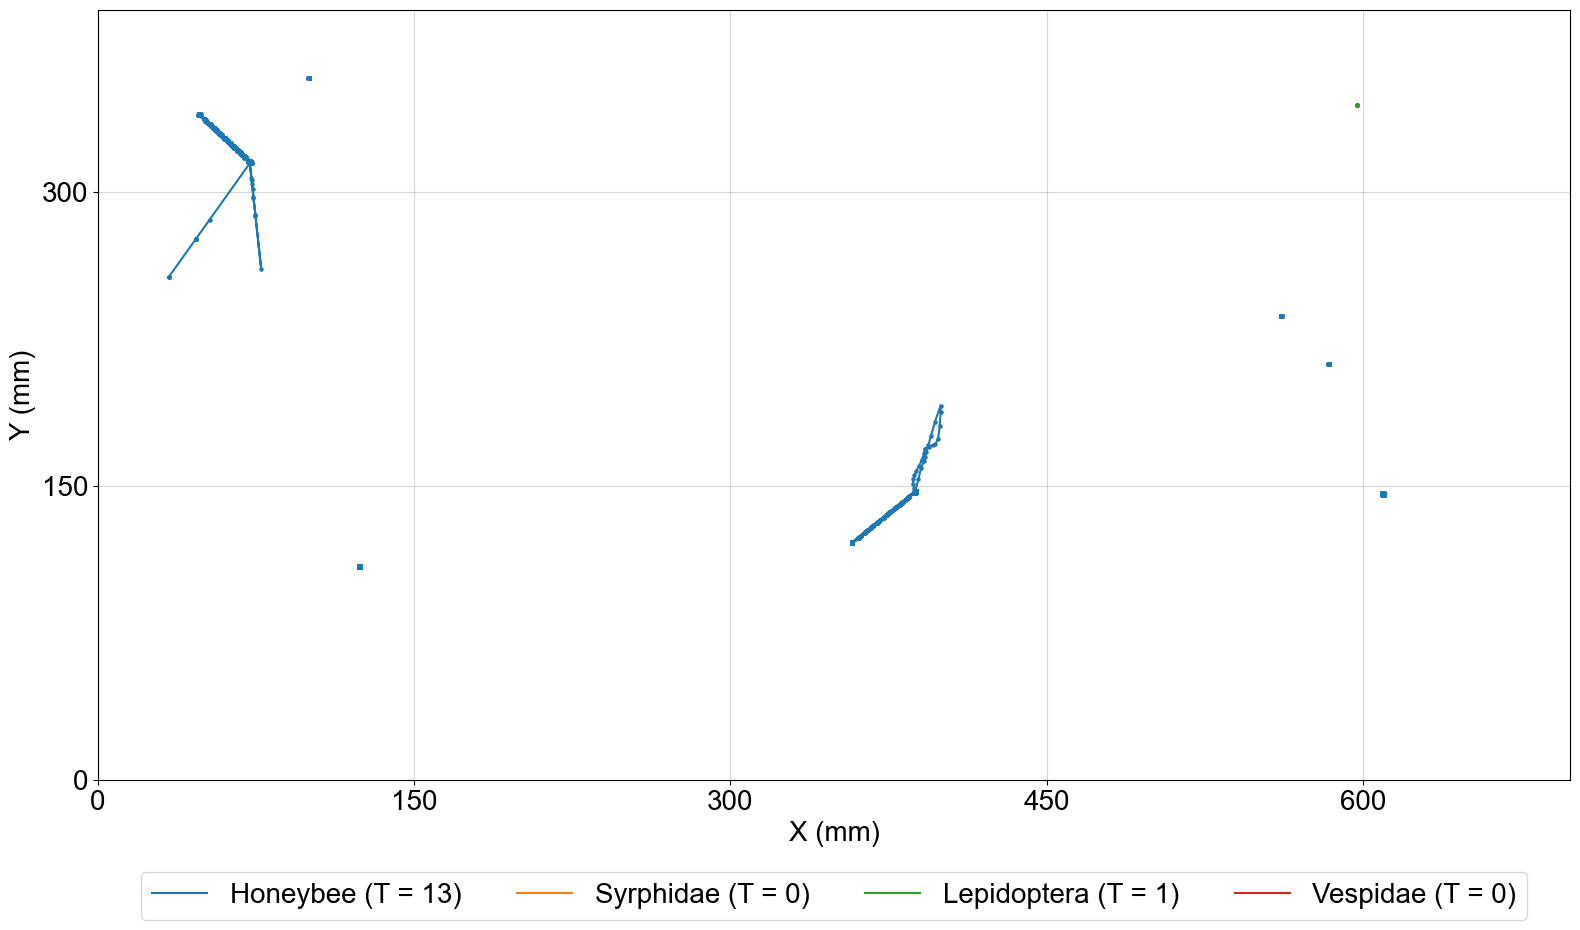

In [48]:
flw_thres = 20/ppmm

plt.figure(figsize=(19,10))

for insect in insect_info:
# insect = insect_info[0]
    x = insect_tracks[f'{insect}_x']
    y = insect_tracks[f'{insect}_y']
    colour = getPlotColor(insect)
    plt.plot(x, y, label=insect, color = colour)
    plt.scatter(x, y, color = colour, s=5)

ax = plt.gca()
for position in position_number_list:
    for row in flower_positions[f'{position}_cx'].dropna().index.tolist():
        ax.add_patch(Circle((flower_positions[f'{position}_cx'][row], flower_positions[f'{position}_cy'][row]), radius = (flower_positions[f'{position}_radius'][row]+flw_thres), color = 'tab:olive', fill=True, alpha = 0.2))
        ax.add_patch(Circle((flower_positions[f'{position}_cx'][row], flower_positions[f'{position}_cy'][row]), radius = (flower_positions[f'{position}_radius'][row]+flw_thres), color = 'k', fill=False, alpha = 0.8))

legend_elements = [Line2D([0], [0], linestyle='-', color=getPlotColor('honeybee_'), label='Honeybee (T = '+str(len(honeybee_tracks))+")", markerfacecolor='k', markersize=10),
                   Line2D([0], [0], linestyle='-', color=getPlotColor('hoverfly_'), label='Syrphidae (T = '+str(len(hoverfly_tracks))+")",markerfacecolor='k', markersize=10),
                   Line2D([0], [0], linestyle='-', color=getPlotColor('moth_'), label='Lepidoptera (T = '+str(len(moth_tracks))+")",markerfacecolor='k', markersize=10),
                   Line2D([0], [0], linestyle='-', color=getPlotColor('wasp_'), label='Vespidae (T = '+str(len(wasp_tracks))+")",markerfacecolor='k', markersize=10)]
                #    Line2D([0], [0], marker="o", color=getPlotColor(11513300101), label='Flowers (T = '+str(flower_count)+")",markerfacecolor='olive', markersize=10, alpha = 0.2)]

# Create the figure
plt.legend(handles=legend_elements, loc=8, ncol=5, frameon=True, fontsize=20, bbox_to_anchor=(0.5, -0.2))

plt.xlabel('X (mm)', fontsize=20)
plt.ylabel('Y (mm)', fontsize=20)
plt.xticks([0, 150, 300, 450, 600],fontsize=20)
plt.yticks([0, 150, 300], fontsize=20)
plt.xlim(0, 1920/ppmm)
plt.ylim(0, 1080/ppmm)
plt.grid(True, alpha = 0.5)


In [50]:

print(len(insect_info))


14


In [52]:
import pandas as pd
import numpy as np

def calculate_total_distance(df):
    def calculate_segment_distance(segment):
        distances = np.sqrt(np.diff(segment['x'])**2 + np.diff(segment['y'])**2)
        return np.sum(distances)
    
    total_distance = 0
    segment = pd.DataFrame(columns=['x', 'y'])
    
    for idx, row in df.iterrows():
        if pd.isna(row['x']) or pd.isna(row['y']):
            if not segment.empty:
                total_distance += calculate_segment_distance(segment)
                segment = pd.DataFrame(columns=['x', 'y'])
        else:
            segment = pd.concat([segment, pd.DataFrame([row])], ignore_index=True)
    
    if not segment.empty:
        total_distance += calculate_segment_distance(segment)
    
    return total_distance

# Example usage
data = {
    'x': [0, 1, 2, np.nan, 3, 4],
    'y': [0, 1, 1, np.nan, 2, 3]
}
df = pd.DataFrame(data)

total_distance = calculate_total_distance(df)
print("Total distance:", total_distance)


Total distance: 3.82842712474619


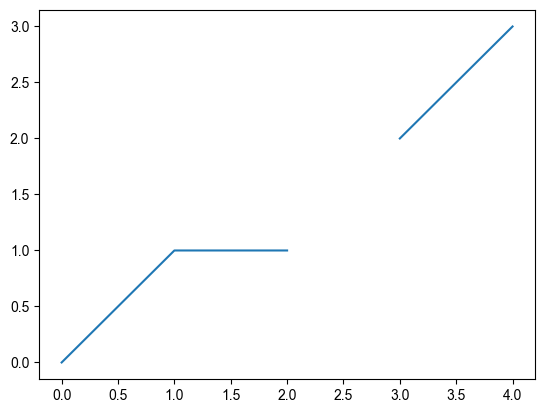

In [54]:
plt.plot(df['x'], df['y'])

In [ ]:
insect_types = []

for insect in insect_info:
    insect_types.append(insect.split('_')[0])
# print(insect_types)

['wasp', 'wasp', 'wasp', 'wasp', 'honeybee', 'moth', 'honeybee', 'honeybee', 'honeybee', 'honeybee', 'honeybee', 'honeybee', 'honeybee', 'honeybee', 'honeybee', 'moth', 'honeybee', 'honeybee', 'honeybee', 'moth', 'honeybee', 'honeybee', 'wasp', 'honeybee', 'moth', 'moth', 'honeybee', 'honeybee', 'honeybee', 'honeybee', 'hoverfly', 'hoverfly', 'hoverfly', 'hoverfly', 'hoverfly', 'honeybee', 'honeybee', 'honeybee', 'honeybee', 'honeybee', 'honeybee', 'honeybee', 'honeybee', 'honeybee', 'honeybee', 'honeybee', 'honeybee', 'honeybee', 'honeybee', 'honeybee', 'hoverfly', 'honeybee', 'honeybee']


In [100]:
#train-3 small-unbalanced

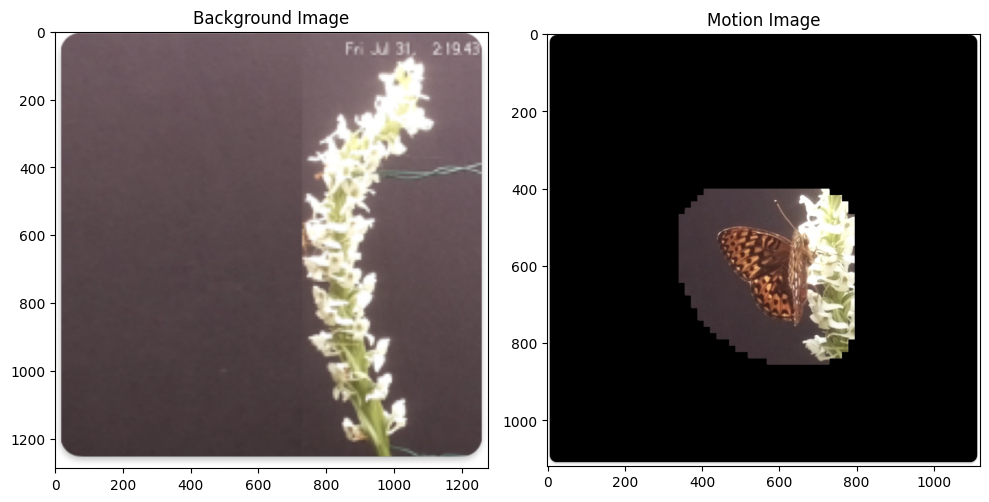

In [5]:
background = '/Users/mrat0010/Library/CloudStorage/GoogleDrive-malika.ratnayake@monash.edu/My Drive/Conferences/CV4Animals-2024/figures/background.png'
motion = '/Users/mrat0010/Library/CloudStorage/GoogleDrive-malika.ratnayake@monash.edu/My Drive/Conferences/CV4Animals-2024/figures/motion.png'


import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Define the filepaths for the background and motion images
background = '/Users/mrat0010/Library/CloudStorage/GoogleDrive-malika.ratnayake@monash.edu/My Drive/Conferences/CV4Animals-2024/figures/background.png'
motion = '/Users/mrat0010/Library/CloudStorage/GoogleDrive-malika.ratnayake@monash.edu/My Drive/Conferences/CV4Animals-2024/figures/motion.png'

# Load the images
background_img = mpimg.imread(background)
motion_img = mpimg.imread(motion)

# Display the images
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.imshow(background_img)
plt.title('Background Image')

plt.subplot(1, 2, 2)
plt.imshow(motion_img)
plt.title('Motion Image')

plt.tight_layout()
plt.show()

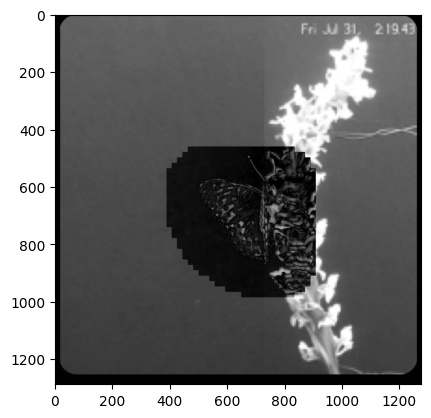

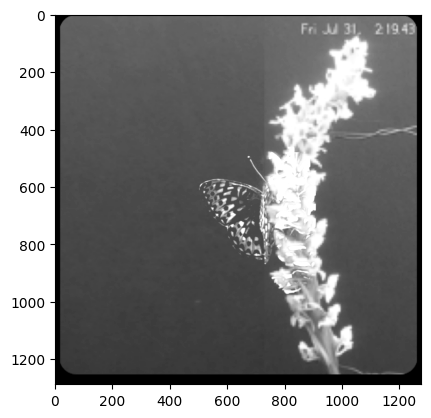

In [35]:
import cv2

background = '/Users/mrat0010/Library/CloudStorage/GoogleDrive-malika.ratnayake@monash.edu/My Drive/Conferences/CV4Animals-2024/figures/background.png'
motion = '/Users/mrat0010/Library/CloudStorage/GoogleDrive-malika.ratnayake@monash.edu/My Drive/Conferences/CV4Animals-2024/figures/motion.png'

# Example code using OpenCV
background = cv2.imread(background)
background_g = cv2.cvtColor(background, cv2.COLOR_BGR2GRAY)

motion = cv2.imread(motion)
motion_g = cv2.cvtColor(motion, cv2.COLOR_BGR2GRAY)

# Resize the motion image to match the background image
resized_motion_image = cv2.resize(motion_g, (background.shape[1], background.shape[0]))



diff_frame = cv2.absdiff(background_g, resized_motion_image )
preprocessed_frame = cv2.add(resized_motion_image, diff_frame)

# Save diff_frame as an image
cv2.imwrite('diff_frame.png', diff_frame)

# Save preprocessed_frame as an image
cv2.imwrite('preprocessed_frame.png', preprocessed_frame)

# # Set the threshold value
# threshold_value = 1

# # Apply the threshold filter to motion_g
# _, motion_g_thresholded = cv2.threshold(motion_g, threshold_value, 255, cv2.THRESH_BINARY)

# Show the resulting thresholded image
plt.imshow(diff_frame, cmap='gray')

plt.show()
#save the image
# plt.savefig('diff_frame.png')

# Show the resulting thresholded image
plt.imshow(preprocessed_frame, cmap='gray')

plt.show()
#save the image
# plt.savefig('preprocessed_frame.png')




# Now both background_g and motion_g_resized have the same size

# # Convert background image to grayscale
# background_image_gray = background_image.convert('L')


# import numpy as np

# # Assuming you have two grayscale images: image1 and image2

# # Convert the images to numpy arrays
# image1_array = np.array(resized_motion_image_gray)
# image2_array = np.array(background_image_gray)

# # Calculate the absolute difference between the two images
# diff = np.abs(image1_array - image2_array)

# # Show the resulting difference image
# plt.imshow(diff, cmap='gray')
# plt.show()

In [94]:
# [[  1.003e+09         986         616        1433           0     0.60107]
#  [  1.004e+09         991         623         380           0           0]]


# Calculate the length of a side using the area
x1, y1 = 986, 616
x2, y2 = 991, 623
bounding_box_area = max(1433, 380)

# Calculate half-widths and half-heights
half_height1 = half_width1 = math.sqrt(bounding_box_area / math.pi)*1.5
# half_width2 = np.sqrt(dl_bounding_box[2])/2
half_height2 = half_width2 = math.sqrt(bounding_box_area / math.pi)*1.5

x1_min, y1_min = x1 - half_width1, y1 - half_height1
x1_max, y1_max = x1 + half_width1, y1 + half_height1
x2_min, y2_min = x2 - half_width2, y2 - half_height2
x2_max, y2_max = x2 + half_width2, y2 + half_height2

# Calculate intersection area
intersection_width = max(0, min(x1_max, x2_max) - max(x1_min, x2_min))
intersection_height = max(0, min(y1_max, y2_max) - max(y1_min, y2_min))
intersection_area = intersection_width * intersection_height
# print("Intersection", intersection_area, intersection_width, intersection_height)

# Calculate union area
union_area = (half_height1*2)*(half_height1*2) + (half_height2*2)*(half_height2*2)  - intersection_area

# Calculate IoU
iou = intersection_area / union_area if union_area > 0 else 0

print(iou)

0.6966937239201825
